# Analysing Twitter WeRateDogs Data 

### Introduction

<p>The reference dataset is the tweet archive of Twitter user @dog_rates, also known as WeRateDogs. WeRateDogs is a Twitter account that rates people's dogs with a humorous comment about the dog. These ratings almost always have a denominator of 10. The numerators, though? Almost always greater than 10. 11/10, 12/10, 13/10, etc. Why? Because "they're good dogs Brent." WeRateDogs has over 4 million followers and has received international media coverage.</p>
<p></p>
<p></p>

### Import all Necessary Libraries

In [1]:
from timeit import default_timer as timer

In [2]:
import os
import requests
import tweepy
import json

In [3]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
%matplotlib inline
sns.set_style("darkgrid")

### Gather all Data

**loading the archive data**

In [5]:
# Twitter archive file
archived_df = pd.read_csv("twitter-archive-enhanced.csv")
archived_df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


**Loading the image prediction data that is hosted on Udacity's servers**

In [6]:
# Loading the image prediction data
# pd.read_csv("image-predictions.tsv", sep="\t")
image_data = requests.get("https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv",)
image_data.status_code

200

In [7]:
image_folder = 'image-prediction'
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

In [8]:
with open(image_folder+'/'+'image-data.tsv', 'wb') as file:
    file.write(image_data.content)

In [9]:
image_df = pd.read_csv(image_folder+'/'+'image-data.tsv', sep='\t')

In [10]:
image_df.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


* tweet_id is the last part of the tweet URL after "status/" → https://twitter.com/dog_rates/status/889531135344209921
* p1 is the algorithm's #1 prediction for the image in the tweet → golden retriever
* p1_conf is how confident the algorithm is in its #1 prediction → 95%
* p1_dog is whether or not the #1 prediction is a breed of dog → TRUE
* p2 is the algorithm's second most likely prediction → Labrador retriever
* p2_conf is how confident the algorithm is in its #2 prediction → 1%
* p2_dog is whether or not the #2 prediction is a breed of dog → TRUE
etc.
* And the #1 prediction for the image in that tweet was spot on

**Additional data from the Twitter API**<br/>
Use the tweet IDs in the archived_df (WeRateDogs Twitter archive) above and query the Twitter API for each tweet's

In [11]:
# API security keys
consumer_key = os.environ.get('TWITTER_API_KEY')
consumer_secret = os.environ.get('TWITTER_API_KEY_SECRET')
access_token = os.environ.get('TWITTER_ACCESS_TOKEN')
access_secret = os.environ.get('TWITTER_ACCESS_TOKEN_SECRET')

In [12]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

In [13]:
api = tweepy.API(auth, wait_on_rate_limit=True)

In [14]:
# verify the tweet id in the archived_df are unique
archived_df.tweet_id.nunique() == archived_df.shape[0]

True

In [15]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
# count = 0
# failed_id = []
# start = timer()
# with open('tweet_json.txt', 'w') as file:
#     for tweet_id in archived_df.tweet_id.values:
#         try:
#             tweet = api.get_status(tweet_id, tweet_mode='extended')
#             json.dump(tweet._json, file)
#             file.write('\n')
#             count += 1
#         except: 
#             failed_id.append(tweet_id)
#             pass
# end = timer()
# print(end - start)

Using the code above above took eternity, and my system eventually crashed. I had to download the tweet-json.txt file from Coursera

**confirmed that the code timed out, i have to extract the unsuccessful ids data again**

In [16]:
count_like_data = []
with open('tweet-json.txt') as file:
    for i in range(archived_df.shape[0]):
        f = file.readlines()
        for line in f:
            data = json.loads(line)
            data_id = data['id']
            retweet_count = data["retweet_count"]
            favorite_count = data["favorite_count"]

            count_like_data.append({
                'tweet_id': data_id,
                'retweet_count': retweet_count,
                'favorite_count': favorite_count
            })

In [17]:
# create a table of the following information: tweet ID, retweet count, and favorite count
count_like_df = pd.DataFrame(count_like_data, columns=['tweet_id', 'retweet_count', 'favorite_count'])

In [18]:
count_like_df.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


### Access all 

#### Access for Messy Issue

###### archived_df: Check if Data is Messy/Untidy

In [19]:
archived_df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [20]:
# 'doggo', 'floofer', 'pupper', 'puppo' features seems to be values of a common feature. Lets unspect it
potential_messy = ['doggo', 'floofer', 'pupper', 'puppo']
for feat in potential_messy:
    print(archived_df[feat].unique())

['None' 'doggo']
['None' 'floofer']
['None' 'pupper']
['None' 'puppo']


The archived data is untidy. The archived_df features: `doggo`, `floofer`, `pupper`, `puppo` are all dog stage names and are suppose to be values of a feature (i will call the feature `stage_name`).

###### image_df: Check if Data is Messy/Untidy

In [21]:
image_df.head(2)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True


###### image_df: Check if Data is Messy/Untidy

In [22]:
count_like_df.head(2)

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819


The dataframe `image_df` and `count_like_df` are tidy enough. The common issue with the three dataset is that they are suppose to be one since they have a common unique features

### Access Data for Low Quality Issue

* **archived_df: Low Quality Issue**

In [23]:
archived_df.head(2)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None


In [24]:
count_like_df.head()

,tweet_id,retweet_count,favorite_count
0,892420643555336193,8853,39467
1,892177421306343426,6514,33819
2,891815181378084864,4328,25461
3,891689557279858688,8964,42908
4,891327558926688256,9774,41048


In [25]:
# number of retweeted values
archived_df[['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp']].notnull().sum()

retweeted_status_id           181
retweeted_status_user_id      181
retweeted_status_timestamp    181
dtype: int64

In [26]:
# columns in the dataset
archived_df.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'retweeted_status_id', 'retweeted_status_user_id',
       'retweeted_status_timestamp', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

In [27]:
# missing values in the dataset for non-retweeted data
archived_missing_val = archived_df.isna().sum().sort_values(ascending=False)
archived_missing_val

in_reply_to_user_id           2278
in_reply_to_status_id         2278
retweeted_status_timestamp    2175
retweeted_status_id           2175
retweeted_status_user_id      2175
expanded_urls                   59
rating_denominator               0
pupper                           0
floofer                          0
doggo                            0
name                             0
tweet_id                         0
rating_numerator                 0
text                             0
source                           0
timestamp                        0
puppo                            0
dtype: int64

In [28]:
# percentage of observation with missing values
print(f"retweet ids: {round((2175/archived_df.shape[0])*100)}")
print(f"reply ids: {round((2278/archived_df.shape[0])*100)}")

retweet ids: 92
reply ids: 97


Text(0, 0.5, 'No of Missing Values')

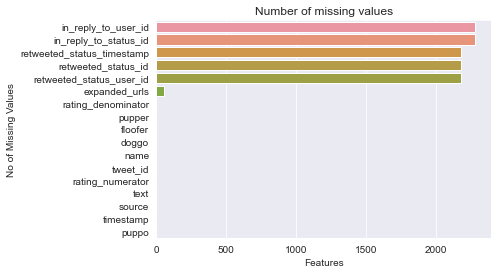

In [29]:
sns.barplot(y=archived_missing_val.index, x=archived_missing_val.values)
plt.title('Number of missing values')
plt.xlabel('Features')
plt.ylabel('No of Missing Values')

In [30]:
# duplicate
archived_df.duplicated().sum()

0

In [31]:
# access the values in the numerator rating
archived_df.rating_numerator.unique()

array([  13,   12,   14,    5,   17,   11,   10,  420,  666,    6,   15,
        182,  960,    0,   75,    7,   84,    9,   24,    8,    1,   27,
          3,    4,  165, 1776,  204,   50,   99,   80,   45,   60,   44,
        143,  121,   20,   26,    2,  144,   88], dtype=int64)

In [33]:
# some numerator values in the text features seems to decimal string 
# but there is no decimal value in the numerator string
# this require further access
accurate = archived_df[archived_df.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]
for i in accurate.index:
    print(f"{accurate.loc[i, 'text']} [values: {accurate.loc[i, 'rating_numerator']}] [index: {i}]")
    print()

This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948 [values: 5] [index: 45]

RT @dog_rates: This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wu… [values: 75] [index: 340]

This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS [values: 75] [index: 695]

This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq [values: 27] [index: 763]

I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace [values: 5] [index: 1689]

Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD [values: 26] [index: 1712]



C:\Users\PT WORLD\anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [34]:
# access the values in the numerator rating
archived_df.rating_denominator.unique()

array([ 10,   0,  15,  70,   7,  11, 150, 170,  20,  50,  90,  80,  40,
       130, 110,  16, 120,   2], dtype=int64)

In [35]:
# valid type
archived_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

* `rating_numerator` and `rating_denominator` should be float type
* `timestamp` should be datatime type

In [36]:
archived_df.source.unique()

array(['<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
       '<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>',
       '<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>',
       '<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>'],
      dtype=object)

* The `source` feature should be a categorical type.
* Also, the values of the `source` feature is still not valid.

* **image_df: Low Quality Issue**

In [37]:
# check for missing values
image_df.isna().sum()

tweet_id    0
jpg_url     0
img_num     0
p1          0
p1_conf     0
p1_dog      0
p2          0
p2_conf     0
p2_dog      0
p3          0
p3_conf     0
p3_dog      0
dtype: int64

In [38]:
# check for invalid data type
image_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [39]:
# check for categorical feature
image_df.nunique()

tweet_id    2075
jpg_url     2009
img_num        4
p1           378
p1_conf     2006
p1_dog         2
p2           405
p2_conf     2004
p2_dog         2
p3           408
p3_conf     2006
p3_dog         2
dtype: int64

`jpg_url` should be a category type

In [40]:
# descriptive name
image_df.columns

Index(['tweet_id', 'jpg_url', 'img_num', 'p1', 'p1_conf', 'p1_dog', 'p2',
       'p2_conf', 'p2_dog', 'p3', 'p3_conf', 'p3_dog'],
      dtype='object')

`jpg_url`, `p1`, `p2`, `p3`, `p1_dog`, `p2_dog`, `p3_dog`, `p1_conf`, `p2_conf` and `p1_conf` should be renamed

* **count_like_df: Low Quality Issue**

In [41]:
count_like_df.isna().sum()

tweet_id          0
retweet_count     0
favorite_count    0
dtype: int64

In [42]:
count_like_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2354 non-null   int64
 1   retweet_count   2354 non-null   int64
 2   favorite_count  2354 non-null   int64
dtypes: int64(3)
memory usage: 55.3 KB


Rename the `id` feature to `tweet_id` as that of `archived_df` and `image_df`

#### Tidiness Issues
1. The archived data is untidy. The archived_df features: `doggo`, `floofer`, `pupper`, `puppo` are all dog stage names and are suppose to be values of a feature (i will call the feature `stage_name`).
2. The three dataset are suppose to be make one dataset since they have a common unique features

#### Quality Issue
1. There are retweeted rows present and we need to remove them.
2. There are many missing values in retweeted id features (`retweeted_status_id`, `retweeted_status_user_id` and `retweeted_status_timestamp`) of the `archived_df`. So they will be dropped.
3. The reply ids features of the archived_df have too many missing values. So they will be dropped aswell.
4. `expanded_urls` feature is has 59 missing but it can be solved given the `tweed_id` is known.
5. Ratings contain some inaccurate values.
6. `rating_numerator` of `archived_df` should be float type.
7. `timestamp` of `archived_df` should be datatime type.
8. Also, the values of the source feature is not accurate.
9. The `source` feature of `archived_df` should be a categorical type.
10. img_num of `image_df` should be a category type
11. `jpg_url`, `p1`, `p2`, `p3`, `p1_dog`, `p2_dog`, `p3_dog`, `p1_conf`, `p2_conf` and `p1_conf` should be renamed for descriptive purpose.

In [43]:
archived_df[archived_df.retweeted_status_id.isna()].shape

(2175, 17)

### Data Cleaning

**Make a copy of all the dataset**

In [44]:
archived_df_copy = archived_df.copy()
count_like_df_copy = count_like_df.copy()
image_df_copy = image_df.copy()

In [45]:
def drop_features(df, features):
    """
    df: dataframe
    features: list of features to drop
    drop the number of features from the df dataframe
    """
    df.drop(features, axis=1, inplace=True)

#### Quality Issue #1: Unwanted Retweeted Observation
`retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` of `archived_df_copy` have `188` retweeted values.

#### Define
Drop all of the retweeted observations .

#### Code

In [46]:
# filtering out the 188 retweeted data
archived_df_copy = archived_df_copy[archived_df_copy.retweeted_status_id.isna()].reset_index(drop=True)
archived_df_copy = archived_df_copy[archived_df_copy.retweeted_status_user_id.isna()].reset_index(drop=True)
archived_df_copy = archived_df_copy[archived_df_copy.retweeted_status_timestamp.isna()].reset_index(drop=True)

#### Test

In [47]:
archived_df_copy[['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2175 entries, 0 to 2174
Data columns (total 3 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   retweeted_status_id         0 non-null      float64
 1   retweeted_status_user_id    0 non-null      float64
 2   retweeted_status_timestamp  0 non-null      object 
dtypes: float64(2), object(1)
memory usage: 51.1+ KB


#### Quality Issue #2: Missing Values
`retweeted_status_id`, `retweeted_status_user_id`, and `retweeted_status_timestamp` of `archived_df_copy` unwanted missing values

#### Define
Drop all of the retweet id features rows.

#### Code

In [48]:
target_features = ['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp']
drop_features(archived_df_copy, target_features)

#### Test

In [49]:
archived_df_copy.columns

Index(['tweet_id', 'in_reply_to_status_id', 'in_reply_to_user_id', 'timestamp',
       'source', 'text', 'expanded_urls', 'rating_numerator',
       'rating_denominator', 'name', 'doggo', 'floofer', 'pupper', 'puppo'],
      dtype='object')

#### Quality Issue #3: Missing Values
`in_reply_to_status_id` and `in_reply_to_user_id` of `archived_df_copy` has large amount of missing values.

#### Define
Drop all of the reply id features rows.

In [50]:
target_features = ['in_reply_to_status_id', 'in_reply_to_user_id']
drop_features(archived_df_copy, target_features)

#### Test

In [51]:
archived_df_copy.columns

Index(['tweet_id', 'timestamp', 'source', 'text', 'expanded_urls',
       'rating_numerator', 'rating_denominator', 'name', 'doggo', 'floofer',
       'pupper', 'puppo'],
      dtype='object')

#### Quality Issue #4: Missing Values
`expanded_url` of `archived_df_copy` contains some missing values.

#### Define
Fill missing expanded url by getting and using the user id and the general url all of the reply ids features

#### Code

In [52]:
# print out an existed expanded url of a user 
print(archived_df_copy.expanded_urls[0])

https://twitter.com/dog_rates/status/892420643555336193/photo/1


In [53]:
# filter all the nan observations in the expanded_urls
missing_pet_id = archived_df_copy[archived_df_copy.expanded_urls.isna()].index
for i in range(archived_df_copy.shape[0]):
    if i in missing_pet_id:
        archived_df_copy.expanded_urls[i] = 'https://twitter.com/dog_rates/status/'+str(archived_df_copy.tweet_id[i])+'/photo/1'

<ipython-input-53-59e42963b834>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  archived_df_copy.expanded_urls[i] = 'https://twitter.com/dog_rates/status/'+str(archived_df_copy.tweet_id[i])+'/photo/1'


#### Test

In [54]:
archived_df_copy.isna().sum()

tweet_id              0
timestamp             0
source                0
text                  0
expanded_urls         0
rating_numerator      0
rating_denominator    0
name                  0
doggo                 0
floofer               0
pupper                0
puppo                 0
dtype: int64

#### Quality Issue #5: Inaccurate Entry
The `rating_numerator` contains an inaccurate value.

#### Define
Replace the inaccurate value in `rating_numerator` of `archived_df_copy` with its correct values.

#### Code

In [55]:
# extract the original values
target_observation = archived_df_copy.text.str.extract(r"([0-9]+\.[0-9]+\/)")
target_observation = target_observation[target_observation[0].notna()][0].str[:-1]
values = target_observation.values
ind = target_observation.index
print(values)
ind

['13.5' '9.75' '11.27' '9.5' '11.26']


Int64Index([42, 558, 617, 1510, 1533], dtype='int64')

In [56]:
for i, v in list(zip(ind, values)):
    archived_df_copy.loc[i, 'rating_numerator'] = v

#### Test

In [59]:
target_index_value = archived_df_copy[archived_df_copy.text.str.contains(r"(\d+\.\d*\/\d+)")][['text', 'rating_numerator']]
for i in target_index_value.index:
    print(f"{archived_df_copy.loc[i, 'text']} [values: {archived_df_copy.loc[i, 'rating_numerator']}] [index: {i}]")
    print()

This is Bella. She hopes her smile made you smile. If not, she is also offering you her favorite monkey. 13.5/10 https://t.co/qjrljjt948 [values: 13.5] [index: 42]

This is Logan, the Chow who lived. He solemnly swears he's up to lots of good. H*ckin magical af 9.75/10 https://t.co/yBO5wuqaPS [values: 9.75] [index: 558]

This is Sophie. She's a Jubilant Bush Pupper. Super h*ckin rare. Appears at random just to smile at the locals. 11.27/10 would smile back https://t.co/QFaUiIHxHq [values: 11.27] [index: 617]

I've been told there's a slight possibility he's checking his mirror. We'll bump to 9.5/10. Still a menace [values: 9.5] [index: 1510]

Here we have uncovered an entire battalion of holiday puppers. Average of 11.26/10 https://t.co/eNm2S6p9BD [values: 11.26] [index: 1533]



C:\Users\PT WORLD\anaconda3\lib\site-packages\pandas\core\strings\accessor.py:101: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


#### Quality Issue #6: Wrong Type
The `rating_numerator` and `rating_denominator` of `archived_df` are integer type

#### Define
Convert the type of `rating_numerator` and `rating_denominator` of `archived_df_copy` should beto float type

#### Code

In [60]:
archived_df_copy.rating_numerator = archived_df_copy.rating_numerator.astype('float')

#### Test

In [61]:
archived_df_copy['rating_numerator'].dtype

dtype('float64')

#### Quality Issue #7: Wrong Type
`timestamp` of `archived_df_copy` is an object type.

#### Define
Convert the type of `timestamp` of `archived_df_copy` to float type.

#### Code

In [62]:
archived_df_copy.timestamp = pd.to_datetime(archived_df_copy.timestamp)

#### Test

In [63]:
archived_df_copy.timestamp.dtype

datetime64[ns, UTC]

#### Quality Issue #8: Inaccurate Source Name
`source` feature of `archived_df_copy` contains the source HTML raw anchor tag code

#### Define
Extract the source name from the hyperlink of the `source` feature of `archived_df_copy`

#### Code

In [64]:
archived_df_copy.source[0]

'<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>'

In [65]:
archived_df_copy.source = archived_df_copy.source.str.extract(r'(>[a-zA-Z].*<)').iloc[:, 0].str[1:-1]

#### Test

In [66]:
archived_df_copy.source.unique()

array(['Twitter for iPhone', 'Twitter Web Client', 'Vine - Make a Scene',
       'TweetDeck'], dtype=object)

#### Quality Issue #9: Wrong Type
`source` of `archived_df_copy` is an integer type

#### Define
Convert the type of `source` of `archived_df_copy` to float type

#### Code

In [67]:
archived_df_copy.source = archived_df_copy.source.astype('category')

#### Test

In [68]:
archived_df_copy.source.dtype

CategoricalDtype(categories=['TweetDeck', 'Twitter Web Client', 'Twitter for iPhone',
                  'Vine - Make a Scene'],
, ordered=False)

#### Quality Issue #10: Wrong Type
`img_num` of `image_df_copy` is an object type

#### Define
Change the type of `img_num` of `image_df_copy` to category type


#### Code

In [69]:
image_df_copy.img_num = image_df_copy.img_num.astype('category')

#### Test

In [70]:
image_df_copy.img_num.dtype

CategoricalDtype(categories=[1, 2, 3, 4], ordered=False)

#### Quality Issue #11: Non Descriptive Name

#### Define
`jpg_url`, `p1`, `p2`, `p3`, `p1_dog`, `p2_dog`, `p3_dog`, `p1_conf`, `p2_conf` and `p1_conf` should be renamed for descriptive purpose.

#### Code

In [71]:
# renaming the image_df
image_df_copy.rename({'jpg_url':'image_url', 'p1':"prediction1", 'p1_conf':"prediction1_confidence", 'p1_dog':'prediction1_is_dog', 
                     'p2':"prediction2", 'p2_conf':"prediction2_confidence", 'p2_dog':'prediction2_is_dog',
                     'p3':"prediction3", 'p3_conf':"prediction3_confidence", 'p3_dog':'prediction3_is_dog'}, 
                     axis=1, inplace=True)

#### Test

In [72]:
image_df_copy.columns

Index(['tweet_id', 'image_url', 'img_num', 'prediction1',
       'prediction1_confidence', 'prediction1_is_dog', 'prediction2',
       'prediction2_confidence', 'prediction2_is_dog', 'prediction3',
       'prediction3_confidence', 'prediction3_is_dog'],
      dtype='object')

#### Tidiness Issue #1: Values as Features
Values of a feature as features

#### Define
Rename the `id` feature of `count_like_df_copy` to `tweet_id` as that of `archived_df` and `image_df`.

#### Code

In [73]:
# create a new series as the size of the archived_df_copy with all None values
archived_df_copy['stage_name'] = pd.Series('None', index=archived_df.index).astype('object')

In [74]:
for i in archived_df_copy.index:
    if archived_df.doggo[i]=="None" and archived_df.floofer[i]=="None" and archived_df.pupper[i]=="None" and archived_df.puppo[i]=="None":
        archived_df_copy.loc[i, 'stage_name'] = 'None'
    elif archived_df.doggo[i]!="None" and archived_df.floofer[i]=="None" and archived_df.pupper[i]=="None" and archived_df.puppo[i]=="None":
        archived_df_copy.loc[i, 'stage_name'] = archived_df.doggo[i]
    elif archived_df.doggo[i]=="None" and archived_df.floofer[i]!="None" and archived_df.pupper[i]=="None" and archived_df.puppo[i]=="None":
        archived_df_copy.loc[i, 'stage_name'] = archived_df.floofer[i]
    elif archived_df.doggo[i]=="None" and archived_df.floofer[i]=="None" and archived_df.pupper[i]!="None" and archived_df.puppo[i]=="None":
        archived_df_copy.loc[i, 'stage_name'] = archived_df.pupper[i]
    else:
        archived_df_copy.loc[i, 'stage_name'] = archived_df.puppo[i]

In [75]:
# dropping all thise features
archived_df_copy.drop(['doggo', 'puppo', 'pupper', 'floofer'], axis=1, inplace=True)

#### Test

In [76]:
archived_df_copy.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage_name
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,None
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,None


#### Tidiness Issue #2: Separated Dataframe
Separated dataframes

#### Define
The dataframe `count_like_df_copy` and `image_df` will be joined to `archived_df` on `tweet_id`.

#### Code

In [77]:
new_df = archived_df_copy.merge(image_df_copy, on='tweet_id').merge(count_like_df_copy, on='tweet_id')

#### Test

In [79]:
new_df.head(2)

,tweet_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,stage_name,image_url,...,prediction1_confidence,prediction1_is_dog,prediction2,prediction2_confidence,prediction2_is_dog,prediction3,prediction3_confidence,prediction3_is_dog,retweet_count,favorite_count
0,892420643555336193,2017-08-01 16:23:56+00:00,Twitter for iPhone,This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,None,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,...,0.097049,False,bagel,0.085851,False,banana,0.076110,False,8853,39467
1,892177421306343426,2017-08-01 00:17:27+00:00,Twitter for iPhone,This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,None,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,...,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True,6514,33819


### Storing Data

**Store as .csv**

In [80]:
# store as csv
new_df.to_csv('twitter_archive_master.csv', index=False)

**STore on Database**

In [81]:
from sqlalchemy import create_engine

In [82]:
# create a database named twitter_archive
db = create_engine('sqlite:///twitter_archive_master.db')

In [83]:
# save the new_df to the twitter_archive database and named it as twitter_archive_master table
new_df.to_sql('twitter_archive_master', db, index=False)

### Analyse and Visualize

In [84]:
df = pd.read_csv('twitter_archive_master.csv')

In [85]:
# create a new feature with value from the division of rating_numerator and rating_denominator
df['rating_ratio'] = df['rating_numerator'] / df['rating_denominator'] 

In [86]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1994 entries, 0 to 1993
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   tweet_id                1994 non-null   int64  
 1   timestamp               1994 non-null   object 
 2   source                  1994 non-null   object 
 3   text                    1994 non-null   object 
 4   expanded_urls           1994 non-null   object 
 5   rating_numerator        1994 non-null   float64
 6   rating_denominator      1994 non-null   int64  
 7   name                    1994 non-null   object 
 8   stage_name              1994 non-null   object 
 9   image_url               1994 non-null   object 
 10  img_num                 1994 non-null   int64  
 11  prediction1             1994 non-null   object 
 12  prediction1_confidence  1994 non-null   float64
 13  prediction1_is_dog      1994 non-null   bool   
 14  prediction2             1994 non-null   

In [87]:
def barplot(x, y, title, xlabel, ylabel):
    """
    x: x values
    y: y values
    title: plot title
    xlabel: axis x label
    ylabel: axis y label
    """
    sns.barplot(x=x, y=y)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()

**Summary Statistics of the numerical features**

In [88]:
df.describe()

,tweet_id,rating_numerator,rating_denominator,img_num,prediction1_confidence,prediction2_confidence,prediction3_confidence,retweet_count,favorite_count,rating_ratio
count,1.994000e+03,1994.000000,1994.000000,1994.000000,1994.000000,1.994000e+03,1.994000e+03,1994.000000,1994.000000,1994.000000
mean,7.358508e+17,12.237101,10.532096,1.203109,0.593941,1.344195e-01,6.024848e-02,2766.753260,8895.725677,1.164875
std,6.747816e+16,41.471197,7.320710,0.560777,0.271954,1.006807e-01,5.089067e-02,4674.698447,12213.193181,4.064302
min,6.660209e+17,0.000000,2.000000,1.000000,0.044333,1.011300e-08,1.740170e-10,16.000000,81.000000,0.000000
25%,6.758475e+17,10.000000,10.000000,1.000000,0.362857,5.393987e-02,1.619283e-02,624.750000,1982.000000,1.000000
50%,7.084748e+17,11.000000,10.000000,1.000000,0.587635,1.174550e-01,4.950530e-02,1359.500000,4136.000000,1.100000
75%,7.877873e+17,12.000000,10.000000,1.000000,0.846285,1.951377e-01,9.159438e-02,3220.000000,11308.000000,1.200000
max,8.924206e+17,1776.000000,170.000000,4.000000,1.000000,4.880140e-01,2.734190e-01,79515.000000,132810.000000,177.600000


**Top 5 most numerator rating values**

In [89]:
nume = df.rating_numerator.value_counts()
nume_df = pd.DataFrame({'nume_value':nume.index, 'nume_count':nume.values})
nume_df['nume_rate'] = nume_df['nume_count'] / sum(nume_df['nume_count'])
nume_df[:5]

,nume_value,nume_count,nume_rate
0,12.0,450,0.225677
1,10.0,419,0.210130
2,11.0,396,0.198596
3,13.0,261,0.130893
4,9.0,151,0.075727


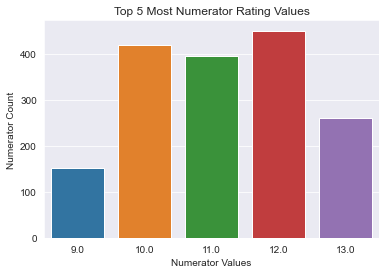

In [90]:
barplot(nume_df['nume_value'][:5], nume_df['nume_count'][:5], "Top 5 Most Numerator Rating Values", "Numerator Values", "Numerator Count")

The highest numerator rating for a pet is `12`

**5 Least numerator rating values?**

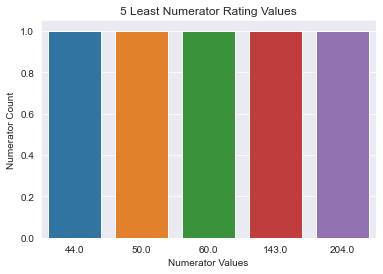

In [91]:
barplot(nume_df['nume_value'][-5:], nume_df['nume_count'][-5:], "5 Least Numerator Rating Values", "Numerator Values", "Numerator Count")

The occurrence of 5 smallest numerator rating is `1`

**What proportion of the data has a denominator rating of 10?**

In [92]:
denom = df.rating_denominator.value_counts()
denom_df = pd.DataFrame({'denom_value':denom.index, 'denom_count':denom.values})
denom_df['denom_rate'] = denom_df['denom_count'] / sum(denom_df['denom_count'])
denom_df

,denom_value,denom_count,denom_rate
0,10,1976,0.990973
1,50,3,0.001505
2,11,2,0.001003
3,80,2,0.001003
4,2,1,0.000502
5,7,1,0.000502
6,20,1,0.000502
7,40,1,0.000502
8,70,1,0.000502
9,90,1,0.000502


C:\Users\PT WORLD\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'No. of Denominator Values')

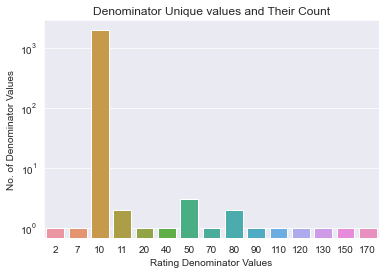

In [93]:
g = sns.countplot(df.rating_denominator)
g.set_yscale('log')
plt.title('Denominator Unique values and Their Count')
plt.xlabel('Rating Denominator Values')
plt.ylabel('No. of Denominator Values')

`99%` of the denominator rating value is `10` and the remaining `1%` of the denominator rating value are between `1` and `14`

**What is the average rating of pets?**

In [94]:
rating_statistic = df.rating_ratio.describe()

In [95]:
rating_statistic_df = pd.DataFrame({'statistics': rating_statistic.index, 'values':rating_statistic.values})
rating_statistic_df

,statistics,values
0,count,1994.000000
1,mean,1.164875
2,std,4.064302
3,min,0.000000
4,25%,1.000000
5,50%,1.100000
6,75%,1.200000
7,max,177.600000


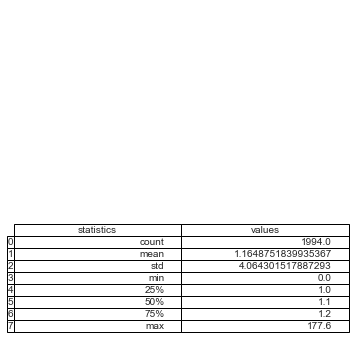

In [96]:
# save the table as an image
ax = plt.subplot(111, frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False) 
pd.plotting.table(ax, rating_statistic_df)
plt.savefig('rate_statistics')

There seems to be an outliers from the visualization above. But the average rating of pets in the dataset is `1.17`.

**Relationship between the numerator rating and the denominator rating**

Text(0, 0.5, 'Rating Numerator')

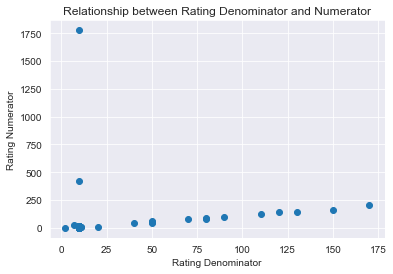

In [97]:
plt.scatter(x='rating_denominator', y='rating_numerator', data=df)
plt.title('Relationship between Rating Denominator and Numerator')
plt.xlabel('Rating Denominator')
plt.ylabel('Rating Numerator')

There seems to be a positive correlation between the rating numerator and denominator. Note, however, that correlation do not imply causation.

**Highest number of pet images**

In [98]:
img_num_count = df['img_num'].value_counts()
img_num_df = pd.DataFrame({'img_num':img_num_count.index, 'img_num_count':img_num_count.values})
img_num_df['img_num_rate'] = img_num_df['img_num_count'] / sum(img_num_df['img_num_count'])
img_num_df

,img_num,img_num_count,img_num_rate
0,1,1711,0.858074
1,2,191,0.095787
2,3,62,0.031093
3,4,30,0.015045


C:\Users\PT WORLD\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Count of Image No.')

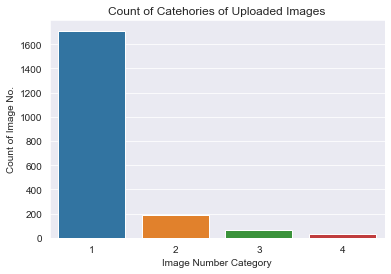

In [99]:
sns.countplot(df['img_num'])
plt.title('Count of Catehories of Uploaded Images')
plt.xlabel('Image Number Category')
plt.ylabel('Count of Image No.')

`85%` of the whole observation has one image (the minimum number of image for a pet in the dataset) for a pet. But only `1%` of the pet has four images which is the highest number of images of a pet in the dataset.

**Does number of image for a pet affects the confidence of it being predicted accurately by the best model?**

In [100]:
img_num_confidence = df.groupby('img_num')['prediction1_confidence'].mean().reset_index()
img_num_confidence

,img_num,prediction1_confidence
0,1,0.571656
1,2,0.702738
2,3,0.766557
3,4,0.815534


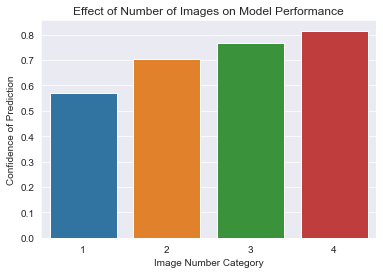

In [101]:
barplot(img_num_confidence['img_num'], img_num_confidence['prediction1_confidence'], 
        'Effect of Number of Images on Model Performance', 'Image Number Category', 'Confidence of Prediction')

As can be seen from above, the number of images for a pet improves the accuracy of the prediction model

**How does ratings relate to favorite_count?**

Text(0, 0.5, 'Favorite Count')

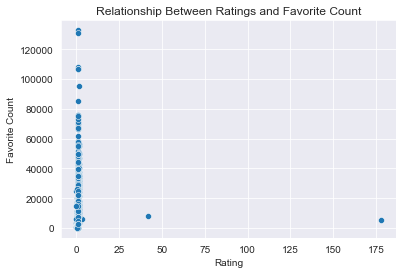

In [102]:
sns.scatterplot(x='rating_ratio', y='favorite_count', data=df)
plt.title('Relationship Between Ratings and Favorite Count')
plt.xlabel('Rating')
plt.ylabel('Favorite Count')

There is no relationship between pet ratings and number of pet twitter favorite count.

**What is the relationship between favorite count and retweet?** 

Text(0, 0.5, 'Favorite Count')

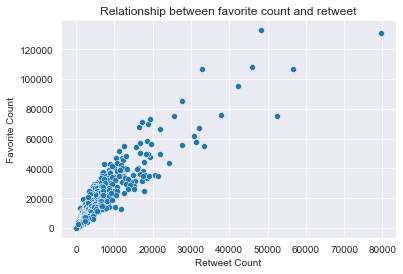

In [103]:
sns.scatterplot(x='retweet_count', y='favorite_count', data=df)
plt.title('Relationship between favorite count and retweet')
plt.xlabel('Retweet Count')
plt.ylabel('Favorite Count')

There is a positive correlation between retweet count and favorite count.

### Conclusion
1.	The highest numerator rating for a pet is 12.
2.	The minimum numerator rating is 1.
3.	99% of the denominator rating value is 10 and the remaining 1% of the denominator rating value is between 1 and 14.
4.	There seems to be an outliers from the visualization above. But the average rating of pets in the dataset is 1.17.
5.	There seems to be a positive correlation between the rating numerator and denominator. Note, however, that correlation do not imply causation.
6.	85% of the whole observation has one image (the minimum number of image for a pet in the dataset) for a pet. But only 1% of the pet has four images which is the highest number of images of a pet in the dataset.
7.	As can be seen from above, the number of images for a pet improves the accuracy of the prediction model.
8. There is no relationship between pet ratings and number of pet twitter favorite count.
9. There is a positive correlation between retweet count and favorite count.

### Limitation
* The data was untidy.
* Data cleaning is a long process but it worths it.

# Thank You